In [38]:
import os
from google import genai
from google.oauth2 import service_account  # 인증 객체 생성을 위해 필요
from google.genai.types import GenerateContentConfig

# 1. JSON 키 파일 경로를 환경 변수에서 가져오기 (보안 강화)
# 환경 변수 설정 방법:
# export GOOGLE_APPLICATION_CREDENTIALS="/path/to/your/key.json"
# export GOOGLE_CLOUD_PROJECT="your-project-id"
KEY_PATH = os.getenv("GOOGLE_APPLICATION_CREDENTIALS", "../../../../../trans-century-405100-c8827a8ffbf4.json")
PROJECT_ID = os.getenv("GOOGLE_CLOUD_PROJECT", "trans-century-405100")
LOCATION = os.getenv("GOOGLE_CLOUD_LOCATION", "us-central1")

# 2. 인증 객체 생성 시 SCOPES 명시 (필수)
# Vertex AI에 접근하기 위한 클라우드 플랫폼 스코프를 추가합니다.
scopes = ['https://www.googleapis.com/auth/cloud-platform']
credentials = service_account.Credentials.from_service_account_file(
    KEY_PATH, 
    scopes=scopes
)

# 3. Client 설정 시 credentials 전달
client = genai.Client(
    vertexai=True, 
    project=PROJECT_ID, 
    location=LOCATION,
    credentials=credentials  # <--- 문자열이 아닌 객체를 전달!
)

# ============================================
# 모델 설정
# ============================================
MODEL_ID = "gemini-2.5-flash"



폰트 설정: Noto Sans CJK JP
Output text: 日本で一番高い山は**富士山（ふじさん）**です。

標高は**3,776メートル**です。


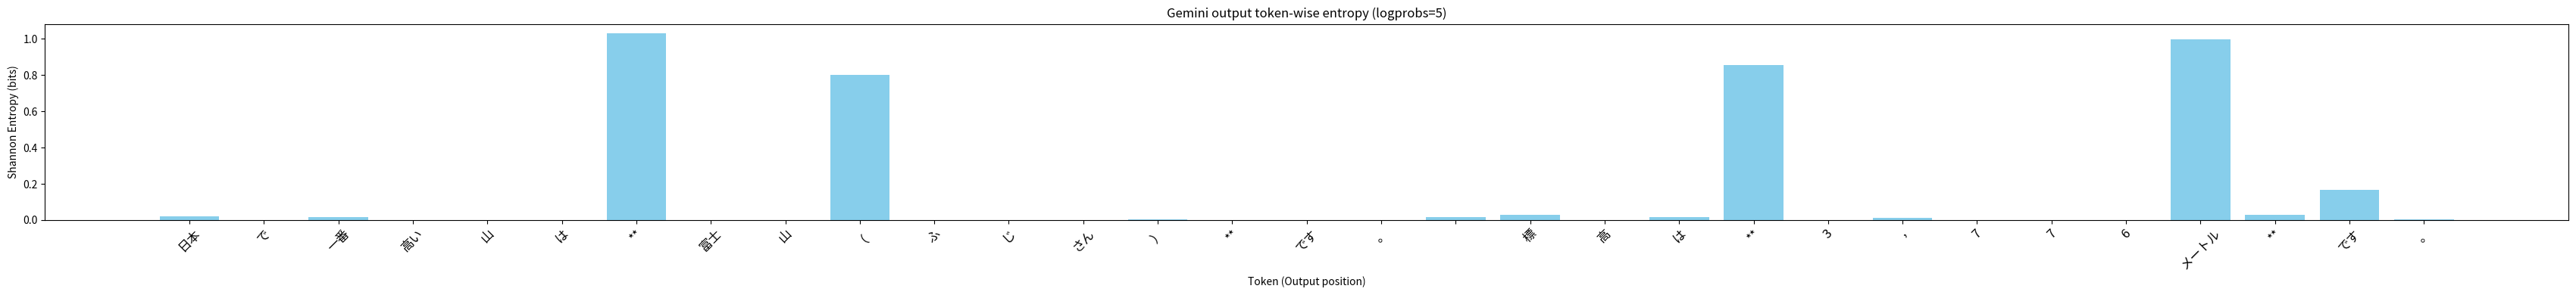

In [37]:
from google import genai
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

# 일본어/한국어/중국어 폰트 설정
def setup_cjk_font():
    """CJK(중국어, 일본어, 한국어) 문자를 지원하는 폰트 찾기 및 설정"""
    # Linux에서 일반적으로 사용 가능한 CJK 폰트 목록
    cjk_fonts = [
        'Noto Sans CJK JP',  # Google Noto Sans (일본어)
        'Noto Sans CJK KR',  # Google Noto Sans (한국어)
        'Noto Sans CJK SC',  # Google Noto Sans (중국어 간체)
        'Noto Sans CJK TC',  # Google Noto Sans (중국어 번체)
        'Noto Sans JP',
        'Noto Sans KR',
        'Noto Sans SC',
        'Noto Sans TC',
        'DejaVu Sans',  # 기본 폰트 (CJK 미지원)
    ]
    
    # 시스템에 설치된 폰트 목록 가져오기
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    # 사용 가능한 CJK 폰트 찾기
    for font_name in cjk_fonts:
        if font_name in available_fonts:
            plt.rcParams['font.family'] = font_name
            print(f"폰트 설정: {font_name}")
            return font_name
    
    # 폰트를 찾지 못한 경우 경고
    print("경고: CJK 폰트를 찾을 수 없습니다. 일본어/한국어/중국어가 제대로 표시되지 않을 수 있습니다.")
    print("설치 방법: sudo apt-get install fonts-noto-cjk")
    return None

# 폰트 설정
setup_cjk_font()

# Gemini-2.5-flash 모델 호출: logprobs=5로 각 위치의 토큰에 대해 상위 5개 logprob 정보를 요청
response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents='日本で一番高い山は？',
    config=genai.types.GenerateContentConfig(
        response_logprobs=True,
        logprobs=5
    )
)

# 출력 문장 추출
output_text = response.candidates[0].content.parts[0].text
print("Output text:", output_text)

# 각 토큰 위치별 토큰 및 top-5 logprob로 shannon entropy 계산
logprobs_result = response.candidates[0].logprobs_result
token_entropies = []
tokens = []

# logprobs_result 구조에 맞게 수정
for i, chosen in enumerate(logprobs_result.chosen_candidates):
    tokens.append(chosen.token)
    
    # top_candidates에서 해당 위치의 상위 후보들 가져오기
    if i < len(logprobs_result.top_candidates):
        top_candidates = logprobs_result.top_candidates[i]
        # top_candidates.candidates에서 확률 추출
        probs = []
        for cand in top_candidates.candidates:
            probs.append(np.exp(cand.log_probability))  # log_probability → 확률
        
        probs_sum = np.sum(probs)
        # (혹시 확률합이 1이 아니면 정규화)
        if probs_sum > 0:
            probs = [p / probs_sum for p in probs]
        else:
            # fallback: 확률이 모두 비정상적으로 0이면 균등분포 가정
            probs = [1/len(top_candidates.candidates)] * len(top_candidates.candidates)
        
        # shannon entropy 계산
        entropy = -np.sum([p*np.log2(p) if p > 0 else 0 for p in probs])
        token_entropies.append(entropy)
    else:
        # top_candidates가 없는 경우 (선택된 토큰만 사용)
        token_entropies.append(0.0)

# 결과 시각화
plt.figure(figsize=(max(6, len(tokens) * 1.1), 4))
plt.bar(range(len(tokens)), token_entropies, color='skyblue')
plt.xticks(range(len(tokens)), tokens, rotation=45, fontsize=12)
plt.xlabel('Token (Output position)')
plt.ylabel('Shannon Entropy (bits)')
plt.title('Gemini output token-wise entropy (logprobs=5)')
plt.tight_layout()
plt.show()
